IESB - TURMA IANA-2020-1 (TURMA A)

INTEGRANTES DO GRUPO:

- Alexandre de Sousa Albuquerque, 2031143037
- Celso de Melo, 2031143004
- Juliano Ortigoso Gaspar, 2031143007

**INSTRUÇÕES**:

- **Mantenha a estrutura de enunciados e células de resposta.**
- **Todas as conclusões devem estar fundamentadas com experimentos e análises de dados que corroborem os aspectos afirmados.**

### Exercício 1

Realize uma análise dos algoritmos de bandidos armados em uma base de avaliações de filmes. O objetivo é treinar um agente para recomendar filmes para os usuários. Neste caso de uso, como a base de dados já foi coletada, será utilizado o recurso de _replay_ para simular um cenário online a partir de uma base de dados offline. Abaixo constam requerimentos e sugestões a respeito da análise do caso de uso. Os integrantes do grupo podem explorar a base para encontrar outros pontos interessantes a serem considerandos.

**OBTENÇÃO DA BASE DE DADOS**

- Para este exercício, uma base de dados referente a avaliações de usuários sobre filmes será utilizada. A base de dados utilizada pode ser baixada com o seguinte comando:
`!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip`

- O arquivo `ratings.csv` contém as informações de avaliações dos usuários e o id do filme. As informações completas dos filmes podem ser encontradas no arquivo `movies.csv`. Para ter as informações completas, recomenda-se realizar o `join` de ambos os arquivos com base nos id's dos filmes. Os arquivos restantes podem ser descartados.

**PREPARAÇÃO DOS DADOS**

- Esta base tem avaliações de usuários no intervalo 0-5. A ideia é transformar o problema em um problema binário com uma avaliação do tipo gostei / não-gostei. Para tal, transforme os valores no intervalo `[0, 5]` em `0` e `1` considerando um limiar. Por exemplo, pode-se considerar que o usuário gostou de um filme quando a nota foi superior a `3`, `4`, ou qualquer outro valor coerente de referência a ser adotado pelo grupo.

- Uma outra abordagem interessante de preparação dos dados pode ser realizar a filtragem de filmes que tenham um número mínimo de avaliações. Por exemplo, pode-se desejar considerar apenas filmes que tenham `2000` avaliações. O valor também pode ser especificado pelo grupo. Isso não só tem a função de fazer o cenário mais interessante como também de reduzir o tamanho da base de dados.

- O grupo pode avaliar e decidir por outros pré-processamentos que sejam interessantes para o resultado final.

**SIMULAÇÃO DO AMBIENTE**

- Como a base de dados é enorme, rodar um cenário de bandidos armados pode ser inviavelmente lento, se os _updates_ forem feitos a cada novo dado. Uma estratégia pode ser compor _batches_ de `n` eventos, requerendo `n/t` passos de treinamento, ao invés de `t` passos.

- Em um cenário clássico, o bandido recomenda apenas um filme e o usuário pode gostar ou não deste filme. Recomendar apenas uma opção pode ser ineficiente para avaliar a política do bandido, especialmente quando há várias opções e um usuário avaliou vários filmes. Para tal, é interessante recomendar um portfólio de filmes, por exemplo os top 5, ou qualquer outro valor de referência. Se o usuário gostar de algum filme do portfólio de filmes, a observação pode ser utilizada para melhorar o algoritmo. Neste caso, torna-se mais provável o bandido receber feedbacks de uma interação que podem ajudar a melhorar o modelo.

- Conforme mencionado no enunciado, como a base de dados já foi coletada e, para simular um ambiente real, é necessário adotar uma estratégia de _replay_. Vocês utilizam a base de dados real para simular novas interações, mas armazena uma história das recomendações do bandido e a reação do usuário à recomendação. Se o usuário gostou ou não gostou da recomendação. A política do bandido é refinada a partir da história com relação às recomendações feitas e não com os valores reais de avaliação dos usuários. Está é a maneira de simular um cenário de interação online a partir de uma base de dados offline.

**IMPLEMENTAÇÃO DO CÓDIGO**

- Será necessário implementar os algoritmos vistos em sala de aula. Para tal, use de esqueleto o código apresentado nos exemplos de bandidos armados apresentados em sala, que tem como core a classe Bandits. Refine o código para adaptar ao cenário em questão.

**ANÁLISES REQUERIDAS**

- Avalie as políticas epsilon-greedy com diferentes valores para epsilon. Avalie no mínimo 6 valores de epsilon, incluído `0%` e `100%`. Conclua qual o melhor hiper-parâmetro para o caso realizando plots e exibindo estatísticas a respeito do desempenho do agente. Por exemplo, podem ser interessantes estátisticas a respeito da recompensa média acumulada no tempo, a respeito da exploração percentual das armas no tempo, dentre outros.

- Avalie as polítics UCB com diferentes valores para a constante `c`. Considere um conjunto de 5 valores que exibam bem comportamentos diferentes do agente segundo o algoritmo UCB. Faça as mesmas análises e conclua qual o melhor hiper-parâmetro para o UCB no caso.

- Exemplos de análises e plots que podem ser realizadas, além de plots a respeito do comportamento dos bandidos podem ser vistos no caso de uso apresentado em [Multi-Armed Bandits: Como fazer boas escolhas](https://medium.com/data-hackers/multi-armed-bandits-como-fazer-boas-escolhas-e73a8422b71d)

- Ao final, conclua a respeito de qual método teve melhor desempenho para este caso de uso.

In [31]:
# CÉLULAS DE CÓDIGO
!nvidia-smi
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import os.path
from numpy.random.mtrand import RandomState

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [32]:
if not os.path.isfile('./ml-25m.zip'):
  !wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip
  !unzip ml-25m.zip

In [33]:
class Ratings:
    """ Classe que carrega o dataset e constroi uma distribuição baseada no rating do filme
        Excluídos os filmes com menos de 10.000 avaliações
  """
    def __init__(self):
        # Carregando os ratings dos filmes
        self.df_ratings = pd.read_csv('./ml-25m/ratings.csv')
        # Transformando as notas 4 e 5 = 1 ; notas 0 a 3 = 0
        self.df_ratings['tumbsup'] = [1 if x >= 4 else 0 for x in self.df_ratings['rating']]

        # Excluindo os filmes com menos de 10000 avaliações
        self.s = self.df_ratings.groupby('movieId')[['movieId']].size().reset_index()
        self.s.rename(columns={0: 'movieCount'}, inplace=True)
        self.df_ratings = self.df_ratings.merge(self.s, how='inner', on='movieId')
        self.df_ratings.drop(self.df_ratings[self.df_ratings['movieCount'] < 10000].index, inplace=True)

        # Calculo da probabilidade de cada filme
        self.s = self.df_ratings.groupby(['movieId'])['tumbsup'].agg('sum').reset_index()
        self.s.rename(columns={'tumbsup': 'tumbsCount'}, inplace=True)
        self.df_ratings = self.df_ratings.merge(self.s, how='inner', on='movieId')
        self.df_ratings['movieProb'] = self.df_ratings['tumbsCount'] / np.max(self.df_ratings['movieCount'])

        # dropando as colunas para economizar memória
        self.df_ratings = self.df_ratings[{'userId', 'movieId', 'tumbsup', 'movieCount', 'tumbsCount', 'movieProb'}]
        self.s = None

    def getRatings(self, r_movieId):
        df = self.df_ratings.loc[self.df_ratings['movieId'] == r_movieId]
        df = df[{'movieId', 'tumbsup'}]
        _movieRatingsList: list = df.pivot(columns="movieId", values="tumbsup")[r_movieId].tolist()
        return _movieRatingsList

    def getMovieList(self):
        return self.df_ratings['movieId'].unique().tolist()



In [34]:
class Bandit:
    """ Classe que define um bandido. 
  """

    def __init__(self, movieId, movie_ratings: list):
        """ Inicia a classe com a distribuição de recompensas baseadas nas avaliacoes do filme.
    """
        self.ratings = movie_ratings
        self.Q_t = 0
        self.t = 0
        self.interact = 0
        self.movieId = movieId

    def pull(self):
        """ Método que define a interação com o bandido. A recompensa é resultante
        de uma distribuição uniforme de média especificada.
    """
        if self.interact >= len(self.ratings):
            _reward = 0
        else:
            _reward = self.ratings[self.interact]
        self.interact += 1
        return _reward

    def update(self, curr_reward):
        """ Método responsável por atualizar a estimação da expectativa da
        recompensa
    """
        self.t += 1
        self.Q_t = self.Q_t + (1.0 / self.t) * (curr_reward - self.Q_t)

    def reset(self):
        """ Método que limpa as estimações prévias de Q_t"""
        self.t = 0
        self.Q_t = 0
        self.interact = 0

In [35]:
def e_greedy_policy(bandits, epsilon=0.1, seed=42):
    """ Função responsável por escolher o bandido segundo uma estratégia epslon-greedy.
      Retorna o bandido correspondente à greedy action.
  """
    Q_values = [b.Q_t for b in bandits]
    if RandomState(seed).choice([True, False], p=[epsilon, 1.0 - epsilon]):
        e_greedy_index = random.choice(range(len(bandits)))
    else:
        e_greedy_index = np.argmax(Q_values)

    e_greedy_bandit = bandits[e_greedy_index]

    return e_greedy_bandit, e_greedy_index


def UCB_policy(bandits):
    """ Função responsável por escolher o bandido segundo uma estratégia UCB.
      Retorna o bandido correspondente à UCB action.
  """
    num_ads = len(bandits)
    ads_selected = []
    total_reward = 0
    numbers_of_selections = [0] * num_ads
    sums_of_reward = [0] * num_ads
    total_reward = 0

    for i in range(0, len(bandits)):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_reward[i] / numbers_of_selections[i]
            delta_i = math.sqrt(2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
    else:
        upper_bound = 1e400
    if upper_bound > max_upper_bound:
        max_upper_bound = upper_bound
        ad = i

        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = dataset.values[n, ad]
        sums_of_reward[ad] += reward
        total_reward += reward

    return rnd_bandit, rnd_index


def interact_with_bandit(bandit):
    """ Função que interage com um bandido. A interação envolve a coleta da
      recompensa e a atualização da média estimada.
  """
    # Coleta a recompensa da interação
    reward = bandit.pull()

    # Atualiza a estimação da média
    bandit.update(reward)

    return reward


def get_mean_cumulative_reward(reward_array):
    cumulative_reward = np.cumsum(reward_array)
    mean_cumulative_reward = cumulative_reward / (np.arange(len(reward_array)) + 1)
    return mean_cumulative_reward


def run_UCB_bandits_experiment(bandits_array, ucb_iterations, c):
    num_iterations = ucb_iterations
    num_ads = len(bandits_array)
    ads_selected = []
    reward_array = []
    numbers_of_selections = [0] * num_ads
    sums_of_reward = [0] * num_ads
    total_reward = 0

    for n in range(0, num_iterations):
        ad = 0
        max_upper_bound = 0
        for i in range(0, num_ads):
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                delta_i = c * math.sqrt(math.log(n + 1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                ad = i
        ads_selected.append(bandits_array[ad].movieId)
        numbers_of_selections[ad] += 1
        reward = bandits_array[ad].pull()
        reward_array.append(reward)
        sums_of_reward[ad] += reward
        total_reward += reward
    print('Recompensa total', total_reward)
    print('Número de seleções', numbers_of_selections)
    print('Recompensas por arma', sums_of_reward)
    print()
    return ads_selected, sums_of_reward, numbers_of_selections, total_reward, reward_array


def run_e_greedy_bandits_experiment(
        bandits_array, num_experiments, greedy_iterations, epsilon, seed):
    """ Simula um cenário dos banditos com a escolha e-greedy de ação """

    rewards_array = np.zeros(greedy_iterations)

    for e in np.arange(num_experiments):
        print(f'Experimento {e}', end='\r')
        list(map(lambda b: b.reset(), bandits_array))
        # list(map(lambda b: print(b.Q_t, b.t, end="\r"), bandits_array))
        # print('\n')

        for n in np.arange(greedy_iterations):
            # Sempre há escolha da ação greedy.
            greedy_bandit, greedy_index = e_greedy_policy(bandits_array, epsilon, seed)

            # Realiza a interação com o bandido que corresponde à ação greedy
            curr_reward = interact_with_bandit(greedy_bandit)

            rewards_array[n] += curr_reward
        # list(map(lambda b: print(b.Q_t, b.t, end="\r"), bandits_array))

    rewards_array /= num_experiments

    return rewards_array



In [36]:
def _init(nr_arms):
    r = Ratings()
    movies_array = random.sample(r.getMovieList(), nr_arms)
    bandits_array = list(map(lambda movie: Bandit(movie, r.getRatings(movie)), movies_array))
    max_interations = min([len(x.ratings) for x in bandits_array])
    return bandits_array, movies_array, max_interations


def main_ucb():
    nr_arms = 10
    # num_iterations = 100000
    r = Ratings()
    movies_array = random.sample(r.getMovieList(), nr_arms)
    bandits_array = list(map(lambda movie: Bandit(movie, r.getRatings(movie)), movies_array))
    num_iterations = max([len(x.ratings) for x in bandits_array])
    ads_selected, sums_of_reward, numbers_of_selections, total_reward, rewards_array = run_UCB_bandits_experiment(
        bandits_array, num_iterations, math.sqrt(2))
    # Percentual de interações que o agente teve com cada arma
    ad_hist = pd.Series(ads_selected).value_counts(normalize=True)
    # ad_hist.hist()
    df_hist = pd.DataFrame(ad_hist).reset_index()
    df_hist.rename(columns={'index': 'ad', 0: 'freq'}, inplace=True)
    # df_hist
    df_hist.plot.scatter(x='ad', y='freq', c='freq', cmap='PuBuGn')
    plt.show()
    # Calculando a recompensa acumulada
    mean_cumulative_reward = get_mean_cumulative_reward(rewards_array)
    # Fazendo o plot da expectativa real dos banditos versus a recompensa média
    plot_comparative(bandits_array, movies_array, [mean_cumulative_reward], num_iterations, 10000, 'Recompensa média acumulada - UCB')


def plot_comparative(bandits_array, movies_array, mean_cumulative_rewards, num_iterations, num_experiments, lbl_police):
    # Fazendo o plot da expectativa real dos banditos versus a recompensa média
    # acumulada
    legends = []
    _max = max([len(x.ratings) for x in bandits_array])
    plt.figure(figsize=(14, 8))
    for p, plot in enumerate(mean_cumulative_rewards):
        if p%2 == 0:
          plt.plot(plot, linestyle=(0, (1, 1)))
        else:
          plt.plot(plot)
        legends.append(lbl_police[p])
    
    for cont, b in enumerate(bandits_array):
        bandit_real_q = (sum(b.ratings) / _max)
        plt.plot(np.ones(num_iterations) * bandit_real_q, linestyle='dashed')
        legends.append(f'Filme {str(movies_array[cont])} - Q = {bandit_real_q:.4f}')
    plt.xscale('log')
    plt.xlabel('Número de iterações')
    plt.ylabel('Recompensa média acumulada')
    plt.title(f'Plot da recompensa média acumulada em {num_experiments} experimentos')
    plt.legend(legends, title = 'Qa média x real', bbox_to_anchor=(1.05, 1), loc='upper left')    
    plt.show()


def e1_e_reedy(qt_bandits, seed, num_experiments):
    epsilon = [0, 0.1, 0.25, 0.5, 0.75, 1]
    # epsilon = [0.1, 0]
    rewards_arrays = []
    mean_cumulative_rewards = []
    lbl_police = []
    bandits_array, movies_array, max_interations = _init(qt_bandits)
    for exp, eps in enumerate(epsilon):
        print(f'\u03B5-greedy com \u03B5 = {epsilon[exp]:.2f}')
        print(f'iterações = {max_interations}')
        rewards_arrays.append(
            run_e_greedy_bandits_experiment(
                bandits_array, num_experiments, max_interations, epsilon[exp], seed))
        mean_cumulative_rewards.append(
            get_mean_cumulative_reward(rewards_arrays[exp]))
        lbl_police.append(f'Recompensa média acumulada - \u03B5 = { epsilon[exp]:.2f}')
    plot_comparative(bandits_array, movies_array, mean_cumulative_rewards, max_interations, num_experiments, lbl_police)


In [37]:
e1_e_reedy(10, 42, 50)

ε-greedy com ε = 0.00
iterações = 11065


KeyboardInterrupt: ignored

In [42]:
def e1_ucb(qt_bandits, num_experiments):
    c = [0, 0.5, 1, math.sqrt(2), 2, 5]
    rewards_arrays = []
    mean_cumulative_rewards = []
    lbl_police = []
    df_hists=[]
    bandits_array, movies_array, max_interations = _init(qt_bandits)
    for _c, eps in enumerate(c):
        print(f'UCB com c = {c[_c]:.2f}')
        print(f'interações = {max_interations}')
        ads_selected, sums_of_reward, numbers_of_selections, total_reward, rewards_array = \
            run_UCB_bandits_experiment(bandits_array, max_interations, c[_c])
        rewards_arrays.append(rewards_array)
        mean_cumulative_rewards.append(
            get_mean_cumulative_reward(rewards_array))
        lbl_police.append(f'Recompensa média acumulada - UCB c = { c[_c]:.2f}')
        ad_hist = pd.Series(ads_selected).value_counts(normalize=True)
        df_hist = pd.DataFrame(ad_hist).reset_index()
        df_hist.rename(columns={'index': 'ad', 0: 'freq'}, inplace=True)
        # df_hist
        df_hists.append(df_hist)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
    lin = 0
    col = 0
    for i, df in enumerate(df_hists):
       
        df.plot.scatter(x='ad', y='freq', c='freq', cmap='PuBuGn', ax = axes[lin, col])
        col+= 1
        if col > 2:
            lin = 1
            col = 0

    plt.show()
    plot_comparative(bandits_array, movies_array, mean_cumulative_rewards, max_interations, num_experiments, lbl_police)


UCB com c = 0.00
interações = 10539
Recompensa total 8040
Número de seleções [2, 7, 1, 1, 1, 10515, 1, 5, 5, 1]
Recompensas por arma [1, 4, 0, 0, 0, 8029, 0, 3, 3, 0]

UCB com c = 0.50
interações = 10539
Recompensa total 6068
Número de seleções [31, 604, 253, 2286, 65, 6977, 7, 65, 212, 39]
Recompensas por arma [10, 329, 129, 1320, 27, 4106, 0, 27, 106, 14]

UCB com c = 1.00
interações = 10539
Recompensa total 5845
Número de seleções [121, 1967, 1388, 6137, 150, 24, 79, 176, 292, 205]
Recompensas por arma [42, 1091, 752, 3599, 56, 0, 22, 69, 130, 84]

UCB com c = 1.41
interações = 10539
Recompensa total 5537
Número de seleções [360, 2380, 1938, 3939, 378, 46, 153, 312, 728, 305]
Recompensas por arma [148, 1308, 1047, 2243, 157, 0, 44, 123, 348, 119]

UCB com c = 2.00
interações = 10539
Recompensa total 5179
Número de seleções [703, 3782, 3072, 88, 514, 88, 321, 652, 925, 394]
Recompensas por arma [297, 2094, 1667, 0, 197, 0, 100, 270, 418, 136]

UCB com c = 5.00
interações = 10539
Reco

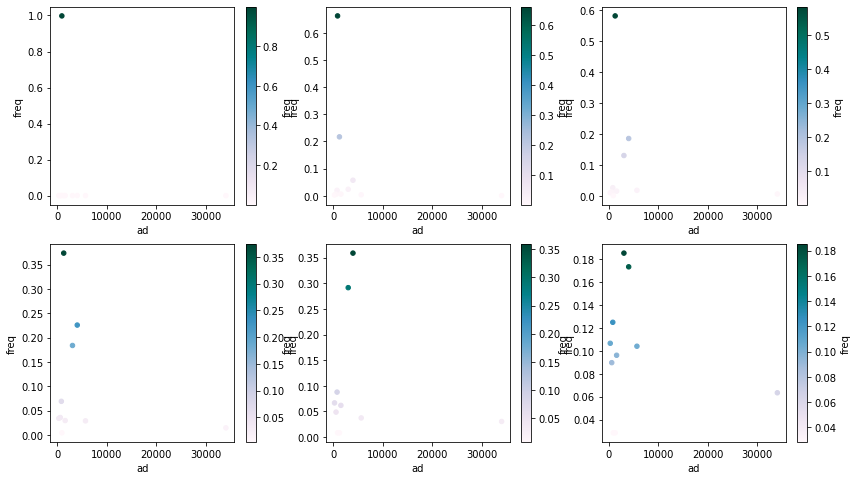

Recompensa média acumulada - UCB c = 0.00
Recompensa média acumulada - UCB c = 0.50
Recompensa média acumulada - UCB c = 1.00
Recompensa média acumulada - UCB c = 1.41
Recompensa média acumulada - UCB c = 2.00
Recompensa média acumulada - UCB c = 5.00


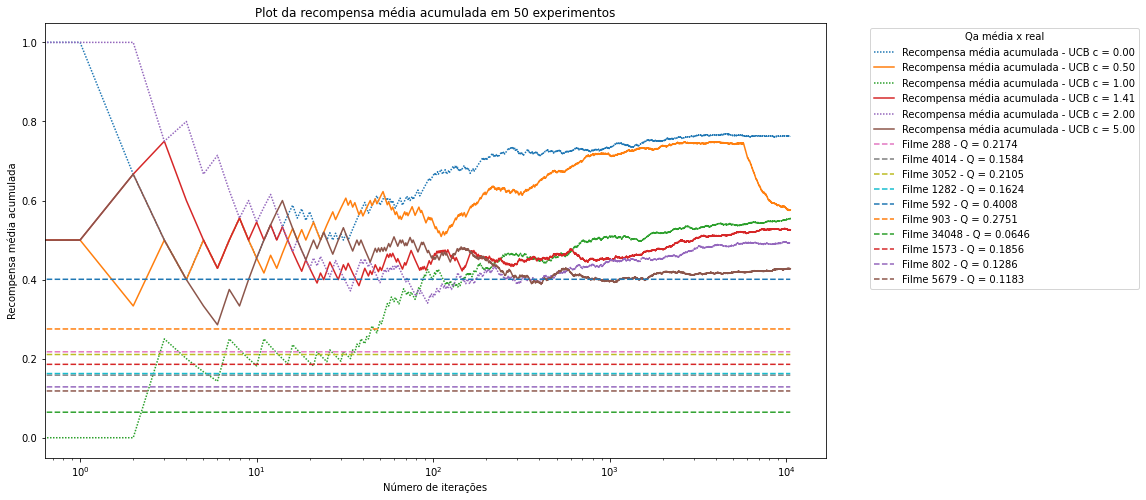

In [43]:

e1_ucb(10, 50)

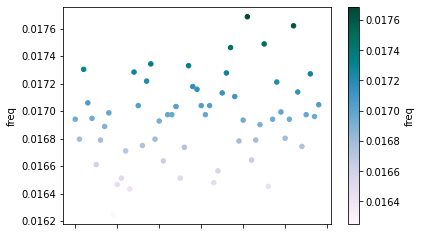

In [ ]:
# Percentual de interações que o agente teve com cada arma
ad_hist = pd.Series(ads_selected).value_counts(normalize=True)
# ad_hist.hist()
df_hist = pd.DataFrame(ad_hist).reset_index()
df_hist.rename(columns={'index':'ad', 0 : 'freq'}, inplace=True )
# df_hist
df_hist.plot.scatter(x='ad', y='freq', c='freq', cmap='PuBuGn')

# UCB

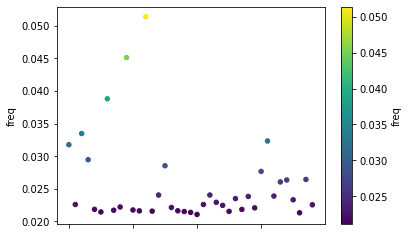

In [ ]:
# Percentual de interações que o agente teve com cada arma
ad_hist = pd.Series(ads_selected).value_counts(normalize=True)
# ad_hist.hist()
df_hist = pd.DataFrame(ad_hist).reset_index()
df_hist.rename(columns={'index':'ad', 0 : 'freq'}, inplace=True )
# df_hist
df_hist.plot.scatter(x='ad', y='freq', c='freq', cmap='viridis')

In [ ]:
df_movies = pd.read_csv('./ml-25m/movies.csv')
df_movies[df_movies['movieId']==318]

,movieId,title,genres
314,318,"Shawshank Redemption, The (1994)",Crime|Drama


In [ ]:
!nvidia-smi

Tue Jun 22 00:52:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Exercício 2

Escolha um dos cenários de gridworld, diferente do apresentado em sala de aula, da biblioteca minigrid. Aplique o método de Monte Carlo ao cenário. 

Mostre a evolução do desempenho do agente exibindo a política greedy em diversas etapas do treinamento. Além disso, exiba gráficos que mostrem o desempenho do agente durante o treinamento.

Ao final, produza um vídeo sobre o desempenho do agente após a etapa de treinamento.

In [ ]:
# CÉLULAS DE CÓDIGO

### Exercício 3

Este exercício refere-se a uma comparação do desempenho do Sarsa e Q-learning no cenário do Windy Gridworld.

Para tal, considere dois cenários do windy gridworld:
1. Um windy gridworld onde o agente também pode se mover pelas diagonais. Este cenário é chamado de **Windy Gridworld with King's Moves**.
1. Um windy gridworld onde o efeito do vento é estocástico, chamado de **Stochastic Windy Gridworld**. Neste cenário, o vento, ao invés de ter um impacto definido deterministicamente, tem um comportamento estocástico: pode mover o agente 1 célula para cima, 1 células para baixo ou manter o valor de vento especificado na coluna. Cada uma dessas situações tem uma probabilidade 1/3 de acontecer.

Responda com relação aos dois algoritmos:
* No **Windy Gridworld with King's Moves**, ter mais ações à disposição otimiza o caminho traçado pelo agente?
* Faça uma comparação com o **Stochastic Windy Gridworld**. Quão mais difícil é este cenário para o agente?
* Houve diferenças significativas entre o Sarsa e o Q-learning em algum dos cenários?

Para fazer as comparações, é interessante exibir a política greedy durante a evolução do treinamento e também após o término do treinamento, além de exibir os gráficos de desempenho do agente.

In [ ]:
# CÉLULAS DE CÓDIGO